<a href="https://colab.research.google.com/github/PyBlin/Study/blob/main/PyML/Chapter4_Classification/Chap4_4_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 4.Random Forest

## 4.1 Random Forest Intro

* Bagging은 Voting과는 다르게, 같은 알고리즘으로 여러 분류기를 만들어서 Voting으로 최종 결정합니다. 대표적으로 Random Forest가 있습니다.
* 빠른 수행과 높은 예측 성능으로 다재다능합니다.
* Decision Tree의 쉽고 직관적인 장점을 그대로 가집니다. (Boosting 대부분이 Decision Tree Algorithm)
* 여러 DT가 배깅으로 샘플링해서 개별적으로 학습한 뒤 최종적으로 보팅을 통해 예측합니다.

* Bootstrapping
>* 여러 데이터셋을 중첩되게 분리하는 방식입니다.
>* Bagging( Bootstrap Aggregating )

* Subset
>* Bootstrapping으로 임의로 만들어진 데이터입니다.
>* 전체 데이터 건수와 동일하지만, 개별 데이터가 중첩되어 만들어집니다.
>* `n_estimators` 하이퍼 파라미터로 Subset을 만듭니다.

In [1]:
from google.colab import drive
drive.mount('/drive')

path = '/drive/MyDrive/Colab/ML_Study/Chapter4_Classification/human_activity/'

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
def get_new_feature_name_df(old_name):
    feature_dup_df = pd.DataFrame(data=old_name.groupby('column_name').cumcount(), 
                                  columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_name = pd.merge(old_name.reset_index(), feature_dup_df, how='outer')
    new_name['column_name'] = new_name[['column_name', 
                                        'dup_cnt']].apply(
                                            lambda x: x[0] + '_' + str(x[1]) 
                                            if x[1] > 0 else x[0], axis=1)
    new_name = new_name.drop(['index'], axis=1)
    return new_name

In [3]:
import pandas as pd

# 이후 자주 사용되므로 함수로 생성 (레이블 칼럼 명은 'action')
def get_human_dataset():

    # 공백 분리 --> sep으로 할당
    feature_name_df = pd.read_csv(path+'features.txt', sep='\s+', 
                              header=None, 
                              names=['column_index', 'column_name'])
    
    # 중복된 피처명을 처리하는 함수를 이용해서 신규 DataFrame 생성
    new_name = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트도 변환
    feature_name = new_name.iloc[:, 1].values.tolist()

    # 학습/테스트 피처 데이터셋 로딩 (칼럼명은 feature_name 적용)
    X_train = pd.read_csv(path+'train/X_train.txt', sep='\s+', 
                          names=feature_name)
    X_test = pd.read_csv(path+'test/X_test.txt', sep='\s+', 
                         names=feature_name)
    
    # 학습/테스트 레이블 데이터셋 로딩 (칼럼명은 'action')
    y_train = pd.read_csv(path+'train/y_train.txt', sep='\s+', 
                          header=None, names=['action'])
    y_test = pd.read_csv(path+'test/y_test.txt', sep='\s+', 
                         header=None, names=['action'])
    
    # 학습/테스트 데이터셋 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Decision Tree 에서 사용한 get_human_dataset()을 이용해 학습/테스트용 df 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# random forest 학습 및 별도의 테스트셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Random Forest Accuracy : {acc:.4f}")

Random Forest Accuracy : 0.9253


## 4.2 Hyper Parameter Tuning

* `n_estimators=10` : decision tree 개수를 지정합니다.
* `max_features='auto'='sqrt'`
* `max_depth`
* `min_samples_leaf`

* Grid Search CV를 이용해 Random Forest Hyper Parameter Tuning을 해보겠습니다.
* `n_estimators` : 100 --> 300
* 멀티 코어 환경에서는 GridSearchCV `n_jobs=-1`를 추가하면 모든 CPU 코어를 이용해 학습합니다.

In [5]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators':[100], 'max_depth':[6, 8, 10, 12], 
          'min_samples_leaf':[8, 12, 18], 'min_samples_split':[8, 16, 20]}

# random forest classifier 객체 생성 후 grid search cv 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print(f"최적 하이퍼 파라미터 : \n{grid_cv.best_params_}")
print(f"\n최고 예측 정확도 : {grid_cv.best_score_:.4f}")

최적 하이퍼 파라미터 : 
{'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}

최고 예측 정확도 : 0.9180


* `n_estimator=300` 으로 하고 별도의 테스트셋에서 예측 성능을 측정해 봅시다!

In [6]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, 
                                 min_samples_leaf=8, min_samples_split=8, 
                                 random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print(f"예측 정확도 : {accuracy_score(y_test, pred):.4f}")

예측 정확도 : 0.9165


* Decision Tree Classifier처럼 `feature_importances_` 속성을 이용해 피처의 중요도를 알 수 있습니다.
* 이 중요도를 막대그래프로 시각화해 봅시다!

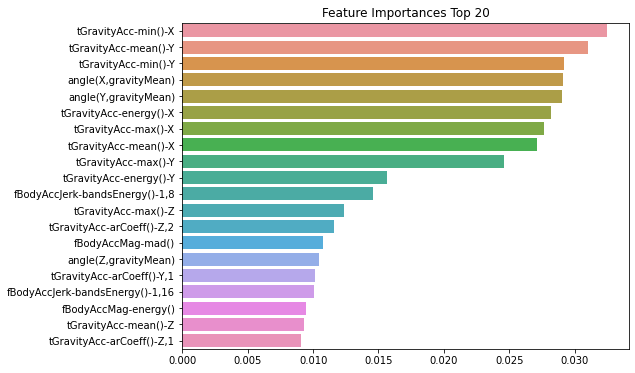

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8, 6))
plt.title('Feature Importances Top 20')
sns.barplot(ftr_top20, ftr_top20.index)
plt.show()